## (1) SET Environment

In [ ]:
import os
os.system('git clone https://github.com/VlOIET/20242R0136COSE47402.git')

0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers

In [ ]:
pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 18.1 MB/s eta 0:00:00


In [ ]:
pip install transformers huggingface-hub

In [ ]:
from huggingface_hub import login
from google.colab import userdata
HF_Token = userdata.get('HF_AT')

login(token=HF_Token)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="XM87RY8f7oIaykIwsDoU")
project = rf.workspace("food-recipe-ingredient-images-0gnku").project("food-ingredients-dataset")
version = project.version(4)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FOOD-INGREDIENTS-dataset-4 in yolov8:: 100%|██████████| 19480/19480 [00:03<00:00, 6089.76it/s]


## (2) Execute Model

In [ ]:
#Environment
DEVICE = "cuda"
DATA_PATH = "/content/FOOD-INGREDIENTS-dataset-4/test/images/019_jpg.rf.5ee07e7c1038cd77c84b18b8130ec2dc.jpg"

YOLO_MODEL_NAME = "/content/20242R0136COSE47402/FinalProject/Output models/YOLO/1202best.pt"
llama_MODEL_PATH = "/content/20242R0136COSE47402/FinalProject/Output models/llama/1203"


image 1/1 /content/FOOD-INGREDIENTS-dataset-4/test/images/019_jpg.rf.5ee07e7c1038cd77c84b18b8130ec2dc.jpg: 640x640 1 Buff Meat, 1 Mushroom, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


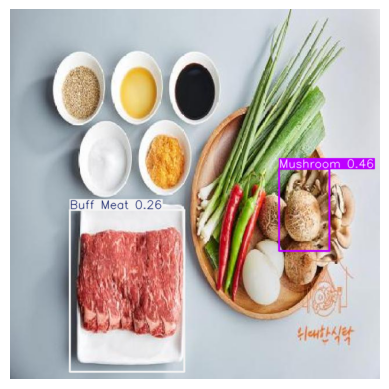

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO(YOLO_MODEL_NAME)

results = model.predict(DATA_PATH)

res_plot = results[0].plot()

plt.imshow(cv2.cvtColor(res_plot, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
ingredient_list =[]

for result in results:
    labels = [model.names[int(cls)] for cls in result.boxes.cls]  # 클래스 인덱스를 레이블로 변환
    ingredient_list.extend(labels)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(llama_MODEL_PATH).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(llama_MODEL_PATH)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# 입력 재료
input_ingredients = ", ".join(ingredient_list)

# 프롬프트 생성
input_text = (
    f"You are an expert chef. Based on the given ingredients, suggest a recipe title and step-by-step cooking directions.\n\n"
    f"Ingredients:\n{input_ingredients}\n\n"
    f"Directions:"
)

In [ ]:
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(DEVICE)
outputs = model.generate(
        input_ids,
        max_length=input_ids.shape[1] + 300,  # Relative max length
        max_new_tokens=300,
        num_return_sequences=1,
        do_sample=True,
        temperature=0.1,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.2,
        no_repeat_ngram_size=2,
        eos_token_id=tokenizer.eos_token_id
)
result = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(result)

Both `max_new_tokens` (=300) and `max_length`(=351) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


You are an expert chef. Based on the given ingredients, suggest a recipe title and step-by-step cooking directions.

Ingredients:
Mushroom, Buff Meat

Directions: 1. Cut mushrooms into small pieces; set aside.  2. Heat oil in large skillet over medium heat. Add meat and saute until no longer pink inside. Stir in mashed potatoes, carrots, celery, salt and pepper to taste. Simmer for about 5 minutes or until vegetables are tender. Serve hot with melted butter if desired.
